In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter
import math
import csv
import os
import pandas as pd

In [3]:
path=r"data_1\0.jpg"
cropped_path=r"arbitrary\x.jpg"

In [6]:
def Feature_1(image_path):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
   # print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel >= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    # print(normalized_count)
    
    # # Plot histogram
    # plt.figure(figsize=(8, 5))
    # sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    # plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    # plt.title('Pixel Intensity Distribution')
    # plt.xlabel('Pixel Intensity')
    # plt.ylabel('Frequency')
    # plt.legend()
    # plt.show()
    
    return float(f"{normalized_count:.4f}")
Feature_1(path)

0.184

In [7]:
#Frobius Norm on entire Image

def Feature_2(image_path):
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Compute the Frobenius norm
    frobenius_norm_value = np.linalg.norm(image_array, 'fro')
    
    return float(f"{frobenius_norm_value:.4f}")

Feature_2(path)

106401.598

In [8]:
def draw_line(r1, c1, r2, c2):
    """
    Generate pixel coordinates for a straight line between two points.
    """
    from skimage.draw import line
    return line(int(r1), int(c1), int(r2), int(c2))

In [9]:

def crop(image_path):
    """
    Applies convex hull processing to the input image, crops the region inside the convex hull,
    shows the overlay image and cropped image side by side in subplots, and returns the cropped image.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        np.ndarray: Cropped image inside the convex hull.
    """
    cropped_path=r"arbitrary\x.jpg"
    
    # Load the image
    image = np.array(Image.open(image_path))
    if image.ndim == 3:  # If it's an RGB image
        gray_image = rgb2gray(image)  # Convert to grayscale
    else:
        gray_image = image  # If already grayscale
    
    # Binarize the image using Otsu's threshold
    threshold = threshold_otsu(gray_image)
    binary_image = gray_image >= threshold  # Convert to binary (foreground/background)
    
    # Label connected components (foreground objects)
    labeled_image, num_labels = label(binary_image, connectivity=2, return_num=True)
    
    # Calculate properties of the labeled regions (connected components)
    regions = regionprops(labeled_image)
    
    # Find the region with the largest area (most significant region)
    largest_region = max(regions, key=lambda r: r.area)
    
    # Get the coordinates of the largest region
    largest_region_coords = largest_region.coords
    
    # Compute the convex hull of the largest region's coordinates
    hull = ConvexHull(largest_region_coords)
    
    # Get the vertices of the convex hull
    hull_points = largest_region_coords[hull.vertices]
    
    # Create a mask from the convex hull
    mask = np.zeros_like(binary_image, dtype=bool)
    rr, cc = polygon(hull_points[:, 0], hull_points[:, 1], mask.shape)
    mask[rr, cc] = True
    
     # Create a bounding box (4-cornered box) around the convex hull
    min_row, min_col = hull_points.min(axis=0)
    max_row, max_col = hull_points.max(axis=0)
    box_corners = np.array([[min_row, min_col],
                            [min_row, max_col],
                            [max_row, max_col],
                            [max_row, min_col]])
    
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    
    # Use the mask to extract the region inside the convex hull
    cropped_image = image[int(min_row):int(max_row), int(min_col):int(max_col)]
    
    # Create subplot with 2 images side by side
    # plt.figure(figsize=(12, 6))  # Adjusted figure size for better clarity
    
    # # Plot the overlay image with convex hull rectangle
    # plt.subplot(1, 2, 1)  # (rows, cols, position)
    # plt.imshow(overlay_image)
    # plt.title('Overlay Image with Convex Hull (Rectangle)')
    # plt.axis('off')
    
    # # Plot the cropped image
    # plt.subplot(1, 2, 2)  # (rows, cols, position)
    # plt.imshow(cropped_image)
    # plt.title('Cropped Image Inside Convex Hull')
    # plt.axis('off')
    
    # # Show the subplots
    # plt.tight_layout()
    # plt.show()
    
    # Save the cropped image as a new file
    cropped_image_pil = Image.fromarray(cropped_image)
    cropped_image_pil.save(cropped_path)
    
   

crop(path)

In [10]:
def Feature_3(path):
    crop(path)
    return Feature_2(cropped_path)

Feature_3(path)


103157.1785

In [11]:
def Feature_4():
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    # Calculate the diagonal length using Pythagorean theorem
    diagonal_length = math.sqrt(width**2 + height**2)
    
    return float(f"{diagonal_length:.4f}")
Feature_4()
# # Example usage
# diagonal = Feature_4()
# # print(diagonal)

1293.4311

In [12]:
def Feature_5():
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    return width

# Example usage
# width = Feature_5()
# print(width)
Feature_5()

592

In [13]:
def Feature_6():
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    return height

# Example usage
# height = Feature_6()
# print(height)
Feature_6()

1150

In [14]:
def Feature_7():
    image_path = r"arbitrary\x.jpg"
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
    # print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel <= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    # print(normalized_count)
    
    # # Plot histogram
    # plt.figure(figsize=(8, 5))
    # sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    # plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    # plt.title('Pixel Intensity Distribution')
    # plt.xlabel('Pixel Intensity')
    # plt.ylabel('Frequency')
    # plt.legend()
    # plt.show()
    
    return float(f"{normalized_count:.4f}")
Feature_7()

0.7705

In [15]:
def Feature_8(image_path):
    image = Image.open(image_path).convert("L")
    image = np.array(image)
    # Define the threshold (127 by default)
    threshold = 127

    # Calculate the number of black and white family pixels
    black_family_pixels = np.sum(image <= threshold)
    white_family_pixels = np.sum(image > threshold)
    ratio=0.0
    # Calculate the ratio
    ratio = white_family_pixels / black_family_pixels
    # if white_family_pixels == 0:
    #     print("No white family pixels found. Ratio cannot be calculated.")
    # else:
       
    #     print(f"Ratio of black family to white family pixels: {ratio:.2f}")
    return float(f"{ratio:.4f}")
Feature_8(path)

0.2313

In [16]:
def Feature(path)->list:
    l:list = [Feature_1(path),Feature_2(path),Feature_3(path),Feature_4(),Feature_5(),Feature_6(),Feature_7(),Feature_8(path)]
    return l

Feature(path)

[0.184, 106401.598, 103157.1785, 1293.4311, 592, 1150, 0.7705, 0.2313]

In [ ]:
output_folder = './data_2'
os.makedirs(output_folder, exist_ok=True)

# Output CSV file path
output_csv = os.path.join(output_folder, 'dataset.csv')

# Open the CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header (optional, adjust as needed)
    csv_writer.writerow(['Feature1', 'Feature2', 'Feature3','Feature4', 'Feature5', 'Feature6','Feature7','Feature8'])  # Update with actual feature names

    # Loop through the range of image files
    for i in range(300):
        # Construct the input file path
        input_path = f'./data_1/{i}.jpg'

        # Check if the file exists
        if os.path.exists(input_path):
            # Get features from the file
            features = Feature(input_path)

            # Write the features to the CSV file
            csv_writer.writerow(features)
        else:
            print(f"File not found: {input_path}")
        print(i)

Image Substraction Outputs

In [ ]:

# Paths
input_folder = "data_1"  # Folder containing input images
output_folder = "data_1_2"  # Folder to save results

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all image files sorted by numeric order
image_files = sorted(
    [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))],
    key=lambda x: int(x.split('.')[0])  # Sort numerically by filename
)

# Sequential image subtraction
for i in range(len(image_files) - 1):
    # Define paths for current and next images
    img1_path = os.path.join(input_folder, image_files[i])
    img2_path = os.path.join(input_folder, image_files[i + 1])

    # Load the images in grayscale
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Perform absolute difference
    diff = cv2.absdiff(img1, img2)

    # Save the result
    output_filename = f"diff_{image_files[i].split('.')[0]}_{image_files[i+1].split('.')[0]}.jpg"
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, diff)

    print(f"Saved: {output_path}")

print("Sequential image subtraction completed. Results saved in:", output_folder)

Feature 9 - Pixel rate Change

\\
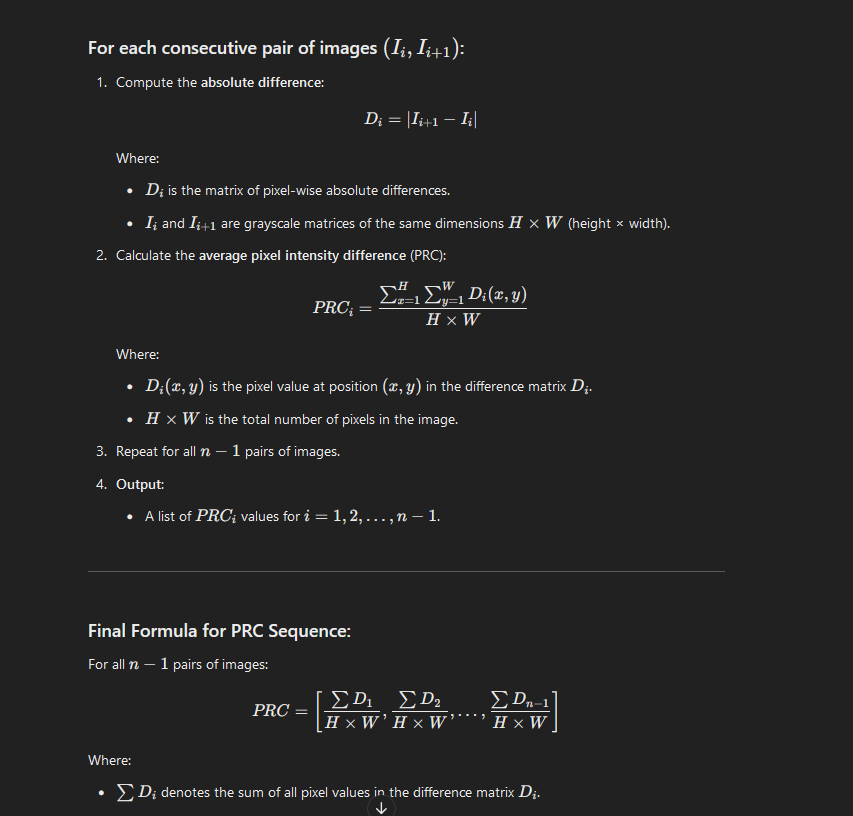

In [ ]:
# Paths
input_folder = "data_1"  # Folder containing input images

# Get all image files sorted by numeric order
image_files = sorted(
    [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))],
    key=lambda x: int(x.split('.')[0])  # Sort numerically by filename
)

# Initialize list to store pixel rate changes
pixel_rate_changes = []

# Sequential image subtraction
for i in range(len(image_files) - 1):
    # Read current and next images
    img1_path = os.path.join(input_folder, image_files[i])
    img2_path = os.path.join(input_folder, image_files[i + 1])

    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Calculate absolute difference
    diff = cv2.absdiff(img1, img2)

    # Calculate the average pixel intensity difference (Pixel Rate Change)
    prc = float(np.mean(diff))
    pixel_rate_changes.append(prc)

    # print(f"PRC for {image_files[i]} - {image_files[i + 1]}: {prc}")

# Plot the results
plt.plot(range(1, len(pixel_rate_changes) + 1), pixel_rate_changes, marker='o')
plt.xlabel("Image Pair Index")
plt.ylabel("Pixel Rate Change (Average Difference)")
plt.title("Pixel Rate Change Over Image Sequence")
plt.show()

Append the List pixel_rate_changes in dataset as feature 9

In [ ]:
# Load your existing dataset
df = pd.read_csv("your_dataset.csv")  # Replace with your dataset's path

# Ensure the lengths match
if len(pixel_rate_changes) != len(df):
    raise ValueError("The length of pixel_rate_changes must match the number of rows in the dataset.")

# Add the Feature9 column
df['Feature9'] = pixel_rate_changes

In [ ]:
df.head()

In [ ]:
# Save the updated dataset back to a file
df.to_csv("updated_dataset.csv", index=False)